# Very Simple IEMM Example

This notebook demonstrates the basic usage of the IEMM (Imprecise Ensemble of Maximum Margin) library with a simple 2D clustering example.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from iemm import IEMM, Loss

## Load and Prepare Data

We'll use a simple synthetic dataset with 2D features for easy visualization.

In [2]:
# Load the synthetic dataset
df = pd.read_csv('data/easy_synth_data.csv')
features = df.iloc[:, :-1].values
feature_names = df.columns[:-1].to_list()

print(f"Dataset shape: {features.shape}")
print(f"Feature names: {feature_names}")

Dataset shape: (200, 2)
Feature names: ['x', 'y']


## Create Initial Clustering with ECM

We use the Evidential C-Means (ECM) algorithm to create an initial credal partition.

In [3]:
# Apply ECM clustering
number_clusters = 2
model = ecm(x=features, c=number_clusters, beta=2, alpha=1, delta=3, disp=False)

# Extract mass functions and focal sets
mass = model['mass_n']
F = model['F'][1:]  # Remove the first element (empty set)

print(f"Number of data points: {mass.shape[0]}")
print(f"Number of focal sets: {mass.shape[1]}")
print(f"Focal sets F: {F}")

Number of data points: 200
Number of focal sets: 3
Focal sets F: [[1. 0.]
 [0. 1.]
 [1. 1.]]


## Visualize the Initial Clustering

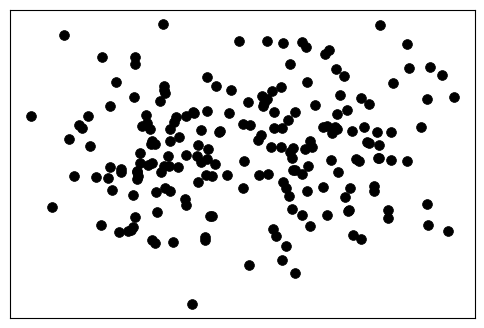

In [4]:
# Plot the data points
plt.figure(figsize=(6, 4))
for i in range(len(features)):
    plt.scatter(features[i, 0], features[i, 1], color='black', linewidth=0.5, s=50)

# plt.title('Initial ECM Clustering')
# plt.xlabel('x')
# plt.ylabel('y')
# remove ticks
plt.xticks([])
plt.yticks([])
# plt.axis('equal')

# save figure
plt.savefig('figures_simple_example/initial_points.pdf', bbox_inches='tight')

plt.show()

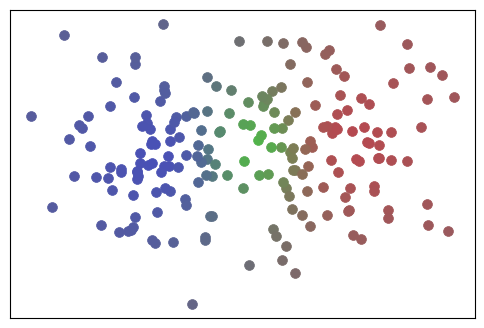

In [5]:
# Define colors for visualization
colors = [
    np.array([73, 80, 182, 255])/255,   # Blue for cluster 1
    np.array([182, 73, 80, 255])/255,   # Red for cluster 2
    np.array([80, 182, 73, 255])/255,   # Green for mixed
]

# Calculate point colors based on mass assignment
point_colors = []
for point in range(len(features)):
    color = np.sum([colors[i] * mass[point, i] for i in range(len(colors))], axis=0)
    color = np.clip(color[:3], 0, 1)
    point_colors.append(color)

# Plot the data points
plt.figure(figsize=(6, 4))
for i in range(len(features)):
    plt.scatter(features[i, 0], features[i, 1], color=point_colors[i], linewidth=0.5, s=50)

# plt.title('Initial ECM Clustering')
# plt.xlabel('x')
# plt.ylabel('y')
# remove ticks
plt.xticks([])
plt.yticks([])
# plt.axis('equal')

# save figure
plt.savefig('figures_simple_example/initial_ev_clustering.pdf', bbox_inches='tight')

plt.show()

## Apply IEMM Classification

Now we'll use the IEMM classifier to create decision boundaries.

In [6]:
# Create and fit IEMM classifier
lambda_mistakeness = 1.0  # Parameter controlling the trade-off
classifier = IEMM(lambda_mistakeness=lambda_mistakeness)
classifier.fit(features, mass, F)

print(f"IEMM classifier trained with lambda = {lambda_mistakeness}")

IEMM classifier trained with lambda = 1.0


## Visualize IEMM Decision Boundaries

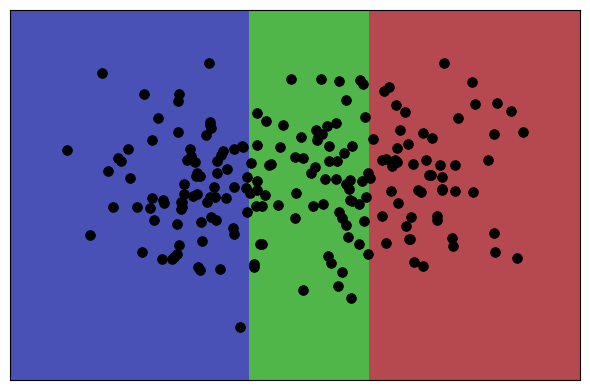

In [7]:
# Create a mesh for decision boundary visualization
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict on mesh points
mesh_points = np.column_stack((xx.ravel(), yy.ravel()))
Z = classifier.predict(mesh_points)
Z = Z.reshape(xx.shape[0], xx.shape[1], -1)

# Create color map for regions
Z_color = np.zeros((xx.shape[0], xx.shape[1], 3))
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        Z_color[i, j] = colors[Z[i, j, 0]][:3]

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(Z_color, extent=(x_min, x_max, y_min, y_max), 
           origin='lower', aspect='auto', alpha=1)

# Plot data points
for i in range(len(features)):
    # plt.scatter(features[i, 0], features[i, 1], color=point_colors[i], linewidth=0.5, s=50)
    plt.scatter(features[i, 0], features[i, 1], color='black', linewidth=0.5, s=50)

# plt.title(f'IEMM Decision Boundaries (λ = {lambda_mistakeness})')
# plt.xlabel('x')
# plt.ylabel('y')
plt.xticks([])
plt.yticks([])
# plt.axis('equal')
# plt.grid(True, alpha=0.3)

# Add legend
focal_sets = ['$\omega_1$', '$\omega_2$', '$\omega_1 \cup \omega_2$']
# for i in range(len(focal_sets)):
#     plt.scatter([], [], color=colors[i][:3], label=focal_sets[i], s=100, edgecolor='black')
# plt.legend(title='Meta-clusters')

plt.tight_layout()

# save figure
plt.savefig('figures_simple_example/iemm_decision_boundaries.pdf', bbox_inches='tight')

plt.show()

## Generate Decision Tree Visualization

IEMM can also generate interpretable decision trees.

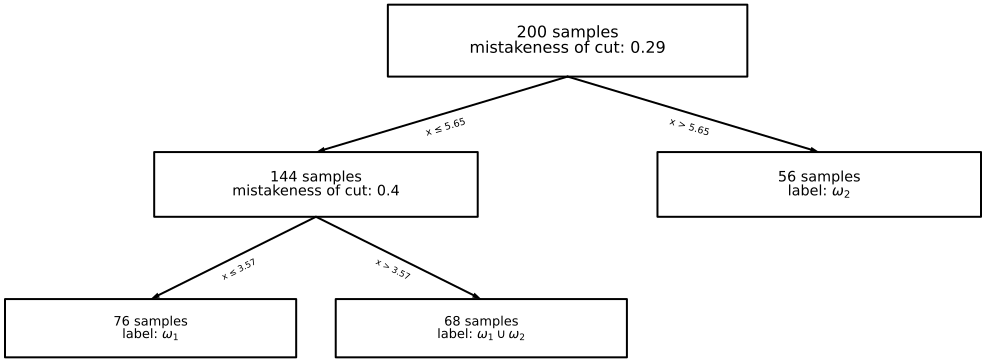

In [8]:
# Generate decision tree diagram
diagram = classifier.plot_tree(
    class_names=['$m_{\omega_1}$', '$m_{\omega_2}$', '$m_{\omega_1 \cup \omega_2}$'],
    cluster_names=focal_sets,
    feature_names=feature_names
)

# Display the decision tree
diagram

## Get Decision Paths

Extract interpretable decision rules from the classifier.

In [9]:
# Get decision paths
try:
    paths = classifier.get_path(['x', 'y'], focal_sets)
    
    print("Decision Rules:")
    for i, path in enumerate(paths):
        print(f"\nRule {i+1}:")
        for key, value in path.items():
            print(f"  {key}: {value}")
except Exception as e:
    print(f"Could not generate paths: {e}")

Decision Rules:

Rule 1:
  $\omega_1$: $(x \leq 3.57)$

Rule 2:
  $\omega_1 \cup \omega_2$: $(x \leq 5.65) \wedge (x > 3.57)$

Rule 3:
  $\omega_2$: $(x > 5.65)$


## Summary

This example demonstrates the basic workflow of using IEMM:

1. **Data Preparation**: Load your 2D dataset
2. **Initial Clustering**: Use ECM to create a credal partition with mass functions
3. **IEMM Training**: Fit the IEMM classifier with your chosen λ parameter
4. **Visualization**: Plot decision boundaries and data points
5. **Interpretation**: Generate decision trees and extract decision rules

The λ parameter controls the trade-off between precision and specificity in the classification. You can experiment with different values to see how it affects the decision boundaries.